In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# =============================================================================
#  Import Section: RANDOM FOREST
# =============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy import interpolate
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter
# Load Data Imports
import load_data as ld
import train_eval_utils as utils
from data_columns import *

# ==================================================================
# Specify paths
# ==================================================================
francis = True
smote = False

# if smote:
#     from imblearn.over_sampling import SMOTE

# NOTE load data path
load_path = "./data_train/parallel/"
if francis: load_path = "/home/daniel/Documents/dash/data/data_train/datasetCombined-2s//" # NOTE
print("Load path: ", load_path)

# Directory for saving winner
out_path_winner = "./rf_output/" + time.strftime("%Y-%m-%d/")
if francis:
    # out_path_winner = "./rf_output/" + time.strftime("francis-%Y-%m-%d-more/") # NOTE
    out_path_winner = "./rf_output/" + time.strftime("francis-%Y-%m-%d/")  # NOTE
if francis and smote:
    out_path_winner = "./rf_output/" + time.strftime("macaroni-smote-%Y-%m-%d/")
if not os.path.isdir(out_path_winner):
    os.makedirs(out_path_winner)
print("Out path parent: ", out_path_winner)

# Directory for saving logger and plots
out_path_log = out_path_winner + "log/"
if not os.path.isdir(out_path_log):
    os.makedirs(out_path_log)

# directory for saving csv log
out_path_pdlogger = out_path_winner + 'log_nseg.csv'
print("CSV logger output: ", out_path_pdlogger)

# ==================================================================
# Load the data
# ==================================================================
print("Loading the data ...")
df_train = ld.load_rf_trainer_data(load_path, verbose=True)
print("The data contains ", len(df_train), " samples.")
# print("INF values in df_train: ", df_train.index[np.isinf(df_train).any(1)])
df_train = df_train.astype('float32')
df_train = df_train[~df_train.isin([np.nan, np.inf, -np.inf]).any(1)]
# print("INF values in df_train: ", df_train.index[np.isinf(df_train).any(1)])
print("The data contains ", len(df_train), " samples AFTER removing inf vals")
# NOTE: modify accordin to the wize analysis plot
# df_train['n-HorznBitRates'][df_train['n-HorznBitRates'] > 3] = 3.0
# print("n-HorznBitRates bigger than 3 removed since class 4.0 had only 160 entries and class 5.0 only 1 entry")

SyntaxError: invalid syntax (load_data.py, line 145)

In [3]:
FEAT_COLS = [x for x in RES_MERGED_COLS if not x in FILTER_COLS]
# print("FEATURE COLS: ", FEAT_COLS)

FEAT_COLS_VEL = [x for x in RES_MERGED_COLS if not x in FILTER_COLS_VEL]

In [4]:
df_feats = df_train[FEAT_COLS_VEL + TARGET_SEGNUMBER].copy()

In [5]:
df_feats.columns

Index(['n-AggBitRates', 'mean-AggBitRates', '25q-AggBitRates',
       '50q-AggBitRates', '75q-AggBitRates', '90q-AggBitrates',
       'mean-ThPutOverLastSeg_bps', 'mean-avgThPutOverWindow_bps',
       '25q-avgThPutOverWindow', '50q-avgThPutOverWindow',
       '75q-avgThPutOverWindow', '90q-avgThPutOverWindow', 'mean-BufferBytes',
       '25q-BufferBytes', '50q-BufferBytes', '75q-BufferBytes',
       '90q-BufferBytes', 'mean-BufferSize', '25q-BufferSize',
       '50q-BufferSize', '75q-BufferSize', '90q-BufferSize', 'mean-Dl-mcs',
       'mode-Dl-mcs', 'mean-Dl-thput', '25q-Dl-thput', '50q-Dl-thput',
       '75q-Dl-thput', '90q-Dl-thput', 'mean-Dl-rsrp', '25q-Dl-rsrp',
       '50q-Dl-rsrp', '75q-Dl-rsrp', '90q-Dl-rsrp', 'mean-Dl-sinr',
       '25q-Dl-sinr', '50q-Dl-sinr', '75q-Dl-sinr', '90q-Dl-sinr',
       'n-HorznBitRates'],
      dtype='object')

In [6]:
means = df_feats.mean(axis=0)

In [7]:
stds = df_feats.std(axis=0)

In [8]:
variances = df_feats.var(axis=0)

In [9]:
df_eval = pd.DataFrame(means, columns=['Mean'])
df_eval['StdDev'] = pd.DataFrame(stds, columns=['StdDev'])
df_eval['Variances'] = pd.DataFrame(variances, columns=['Variance'])

In [10]:
df_feats['n-HorznBitRates'].value_counts()

0.0    89744
1.0    52925
2.0     7201
3.0     2100
4.0      173
5.0        1
Name: n-HorznBitRates, dtype: int64

In [11]:
df_feats.loc[df_feats['n-HorznBitRates'] > 3.0, 'n-HorznBitRates'] = 3.0

In [12]:
df_feats['n-HorznBitRates'].value_counts()

0.0    89744
1.0    52925
2.0     7201
3.0     2274
Name: n-HorznBitRates, dtype: int64

In [13]:
import seaborn as sns
sns.set(style="ticks")

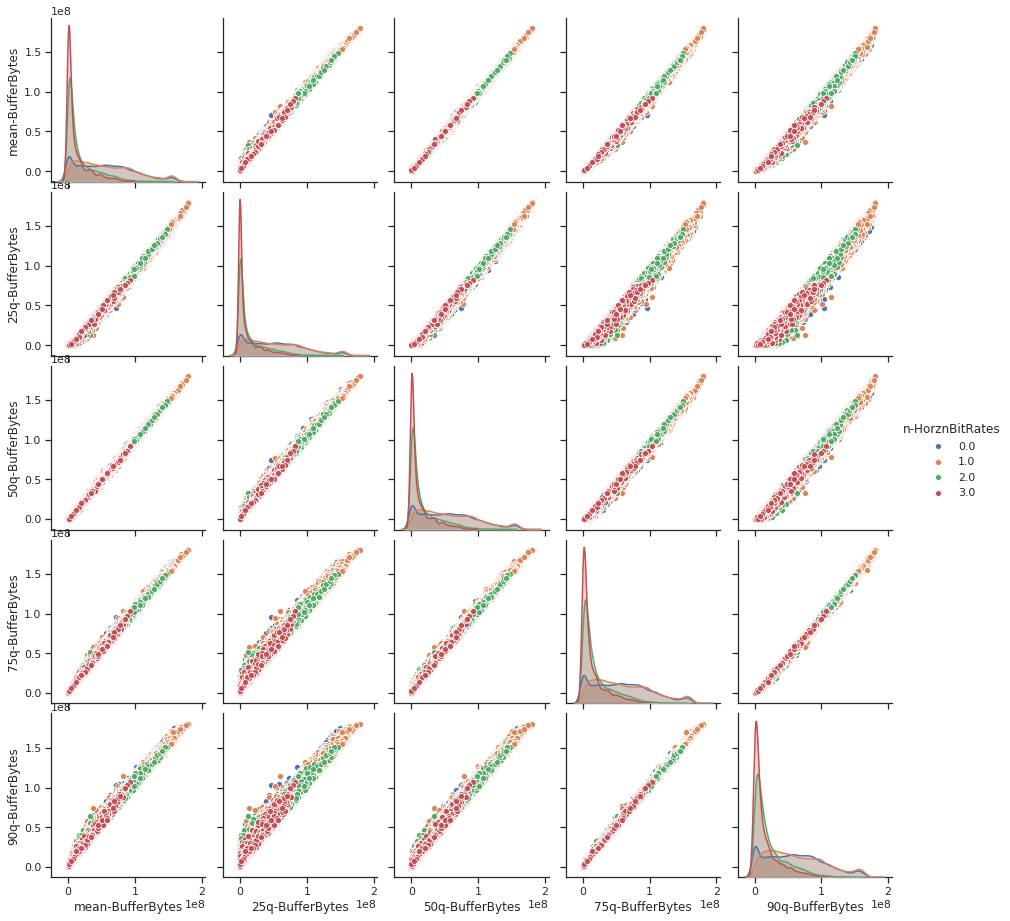

In [14]:
df_plot_buffbytes = df_feats[BUFF_BYTES_COLS + TARGET_SEGNUMBER].copy()
sns.pairplot(df_plot_buffbytes, hue="n-HorznBitRates")

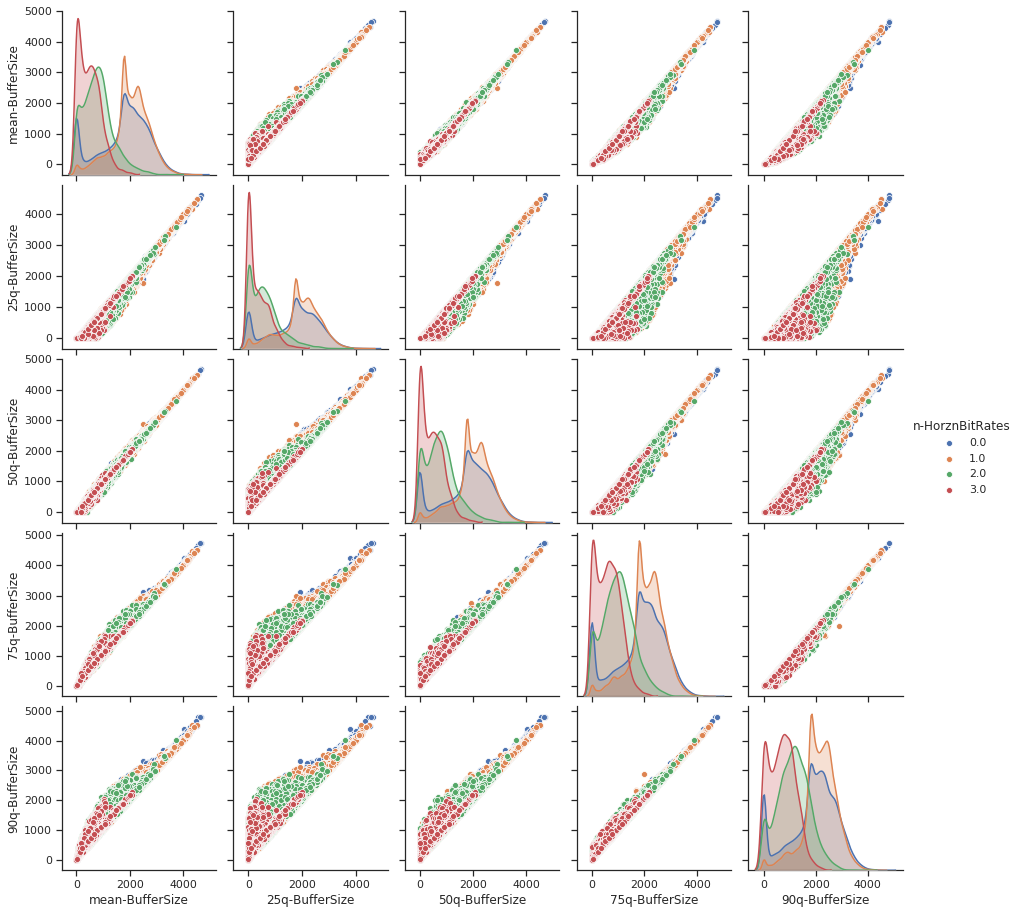

In [15]:
df_plot_buffsize = df_feats[BUFF_SIZE_COLS + TARGET_SEGNUMBER].copy()
sns.pairplot(df_plot_buffsize, hue="n-HorznBitRates")

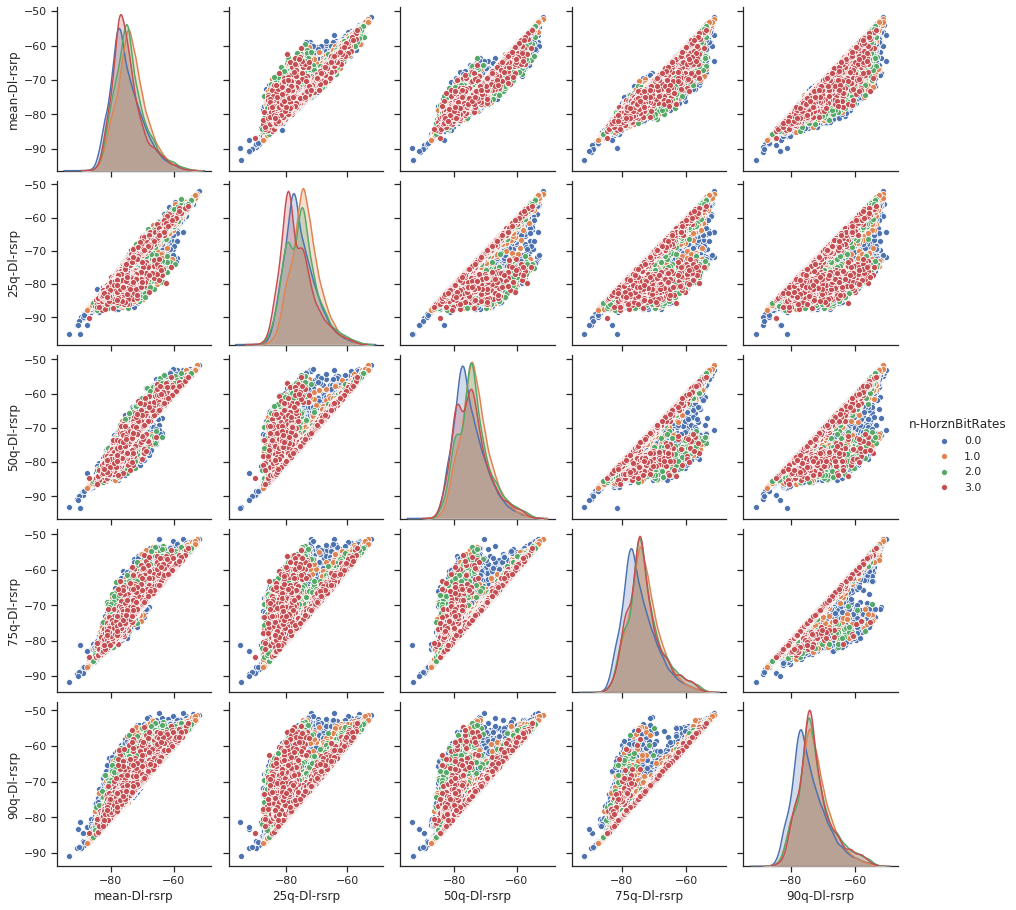

In [16]:
df_plot_rsrp = df_feats[RSRP_COLS + TARGET_SEGNUMBER].copy()
sns.pairplot(df_plot_rsrp, hue="n-HorznBitRates")

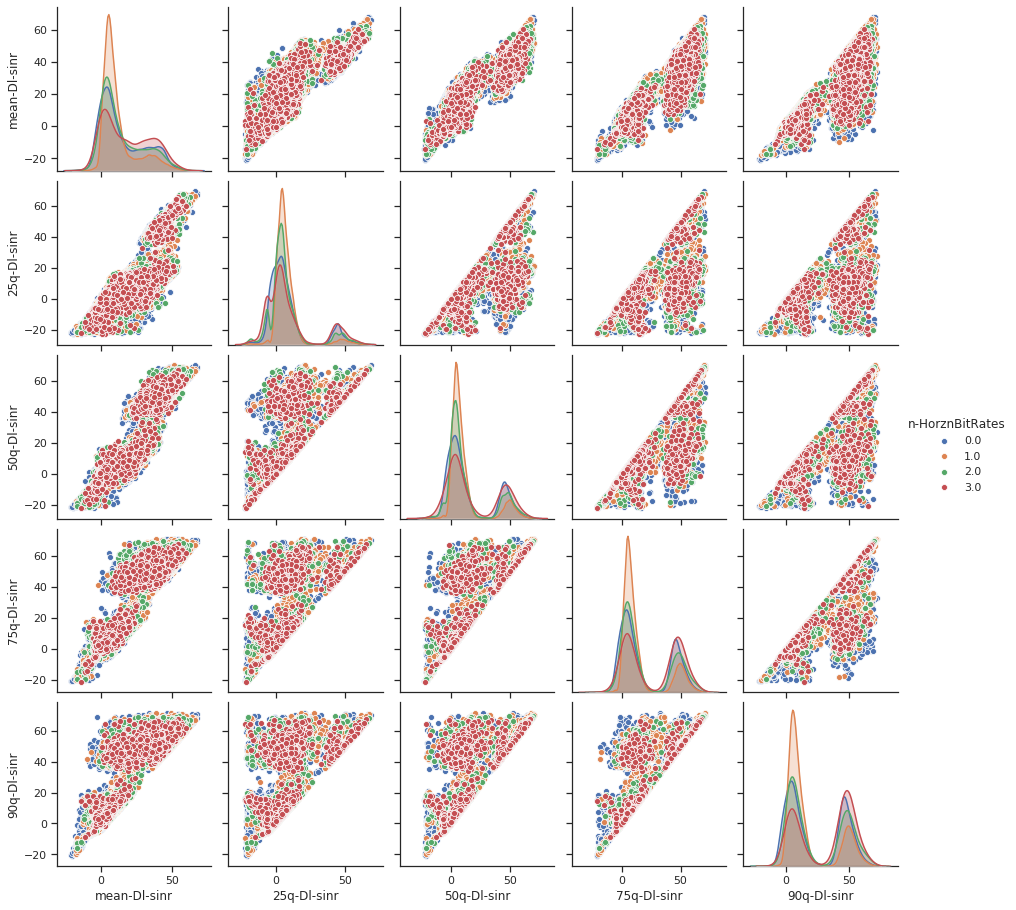

In [17]:
df_plot_sinr = df_feats[SINR_COLS + TARGET_SEGNUMBER].copy()
sns.pairplot(df_plot_sinr, hue="n-HorznBitRates")

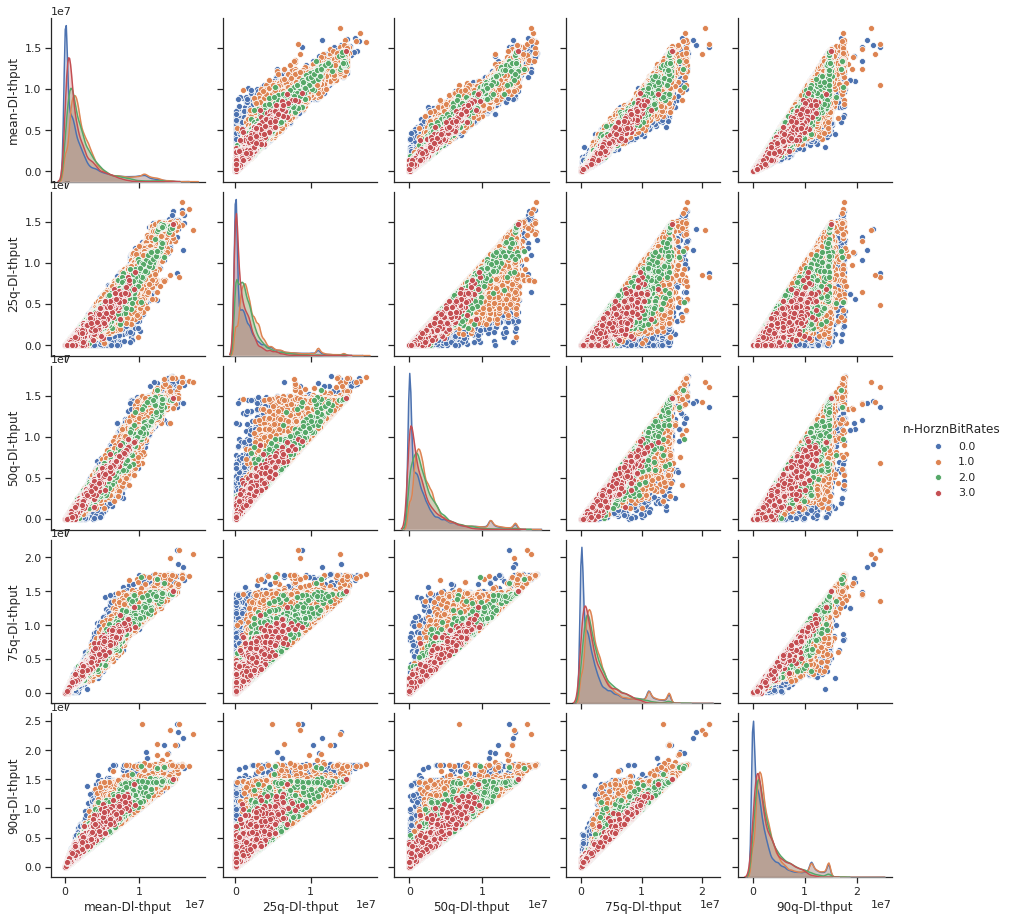

In [18]:
df_plot_dlmacthput = df_feats[DL_MAC_THPUT_COLS + TARGET_SEGNUMBER].copy()
sns.pairplot(df_plot_dlmacthput, hue="n-HorznBitRates")

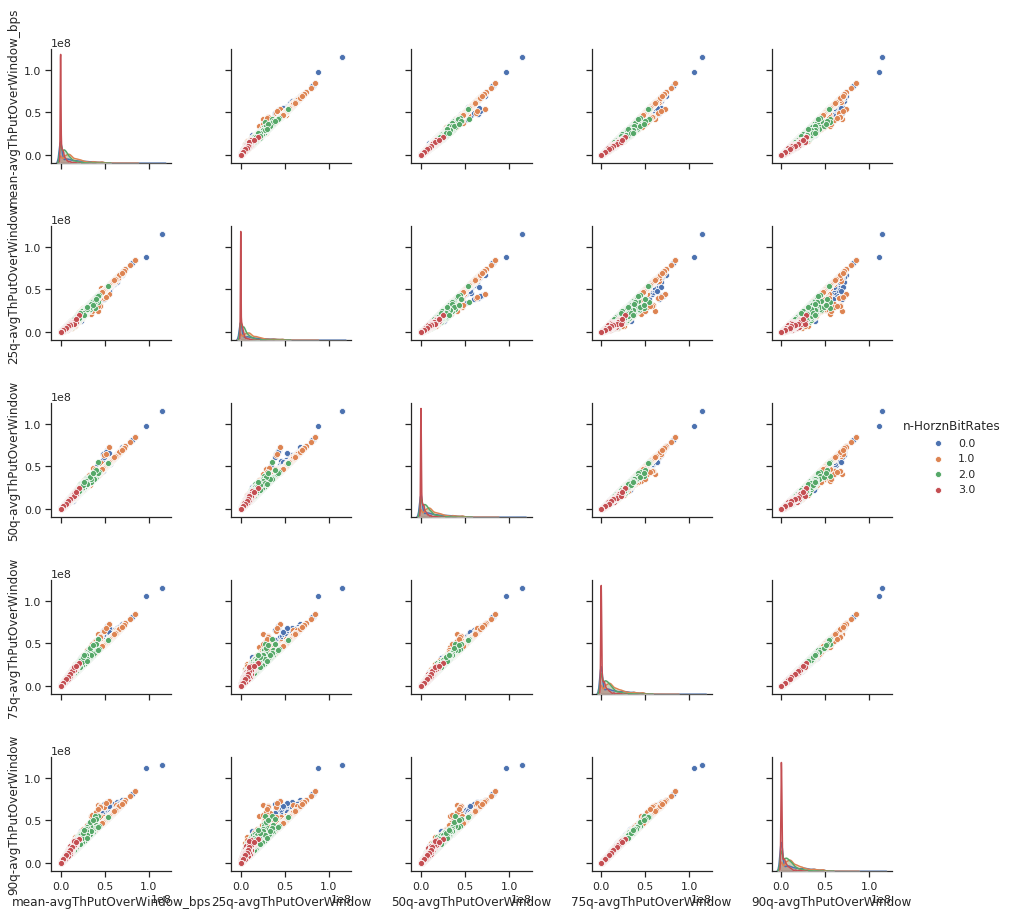

In [19]:
df_plot_dashthput = df_feats[DASH_AVG_THPUT_COLS + TARGET_SEGNUMBER].copy()
sns.pairplot(df_plot_dashthput, hue="n-HorznBitRates")

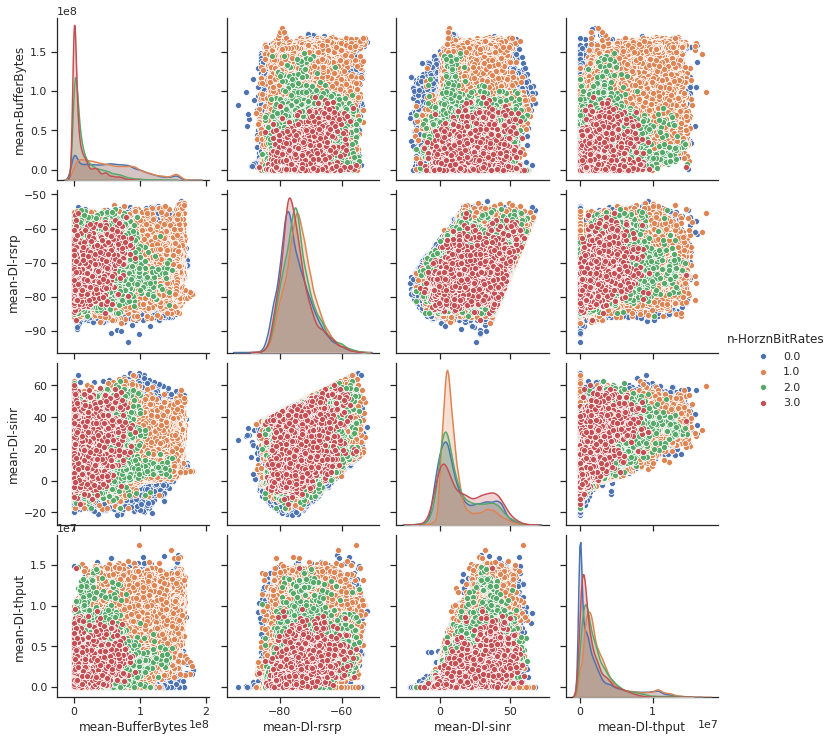

In [20]:
COMBINED_COLS = ['mean-BufferBytes', 'mean-Dl-rsrp', 'mean-Dl-sinr', 'mean-Dl-thput']
df_plot_combined = df_feats[COMBINED_COLS + TARGET_SEGNUMBER].copy()
sns.pairplot(df_plot_combined, hue="n-HorznBitRates")

In [21]:
df_feats['n-HorznBitRates'].value_counts()

0.0    89744
1.0    52925
2.0     7201
3.0     2274
Name: n-HorznBitRates, dtype: int64

In [22]:
df_binary = df_feats.copy()
df_binary.loc[df_binary['n-HorznBitRates'] > 0.0, 'n-HorznBitRates'] = 1

In [23]:
df_binary['n-HorznBitRates'].value_counts()

0.0    89744
1.0    62400
Name: n-HorznBitRates, dtype: int64

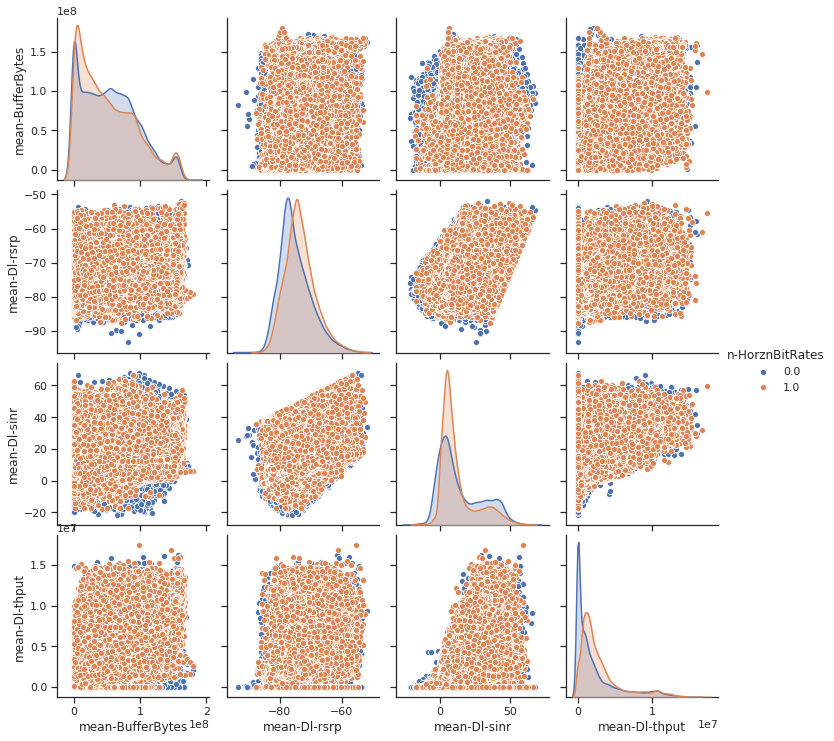

In [24]:
COMBINED_COLS = ['mean-BufferBytes', 'mean-Dl-rsrp', 'mean-Dl-sinr', 'mean-Dl-thput']

df_plot_binary_combined = df_binary[COMBINED_COLS + TARGET_SEGNUMBER].copy()
sns.pairplot(df_plot_binary_combined, hue="n-HorznBitRates")

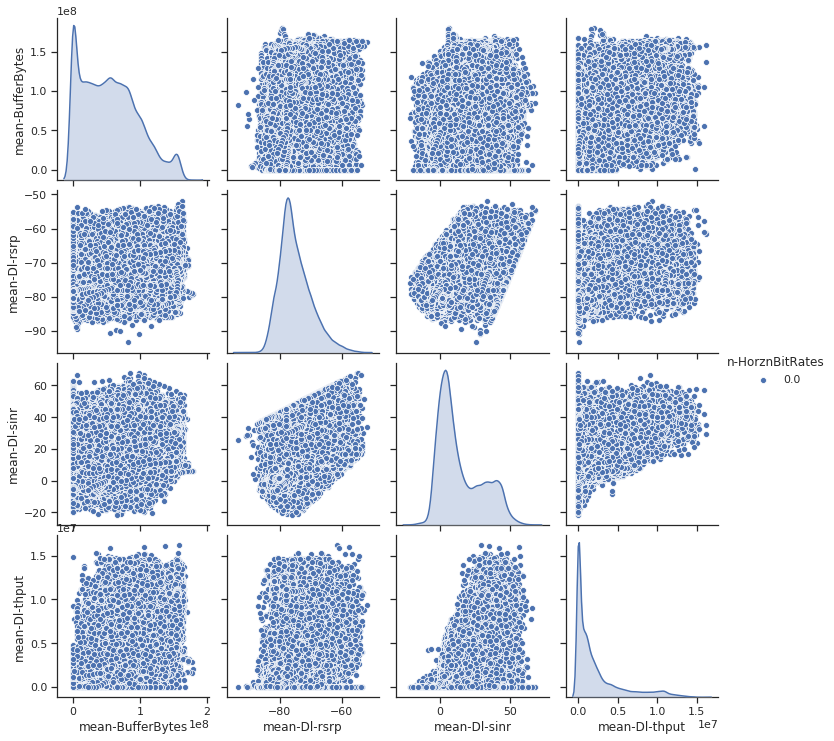

In [25]:
COMBINED_COLS = ['mean-BufferBytes', 'mean-Dl-rsrp', 'mean-Dl-sinr', 'mean-Dl-thput']
df_binary_tmp = df_binary.copy()
df_binary_tmp = df_binary_tmp.loc[df_binary_tmp['n-HorznBitRates'] < 1.0]
df_plot_binary_combined_tmp = df_binary_tmp[COMBINED_COLS + TARGET_SEGNUMBER].copy()
sns.pairplot(df_plot_binary_combined_tmp, hue="n-HorznBitRates")